In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Checking device for run
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Preparing Data

Using Fashion MNIST dataset to experiment

### Downloading and initializing data
Initializing built-in pytorch fashion MNIST dataset

In [2]:
FMNIST_traindata = datasets.FashionMNIST("./data", download=True, train=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
FMNIST_testdata = datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

FMNIST_trainloader = torch.utils.data.DataLoader(FMNIST_traindata, batch_size=100, shuffle=True)
FMNIST_testloader = torch.utils.data.DataLoader(FMNIST_testdata, batch_size=100, shuffle=True)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
# Dictionary to identify label tags in FashionMNIST dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Showcasing sample data

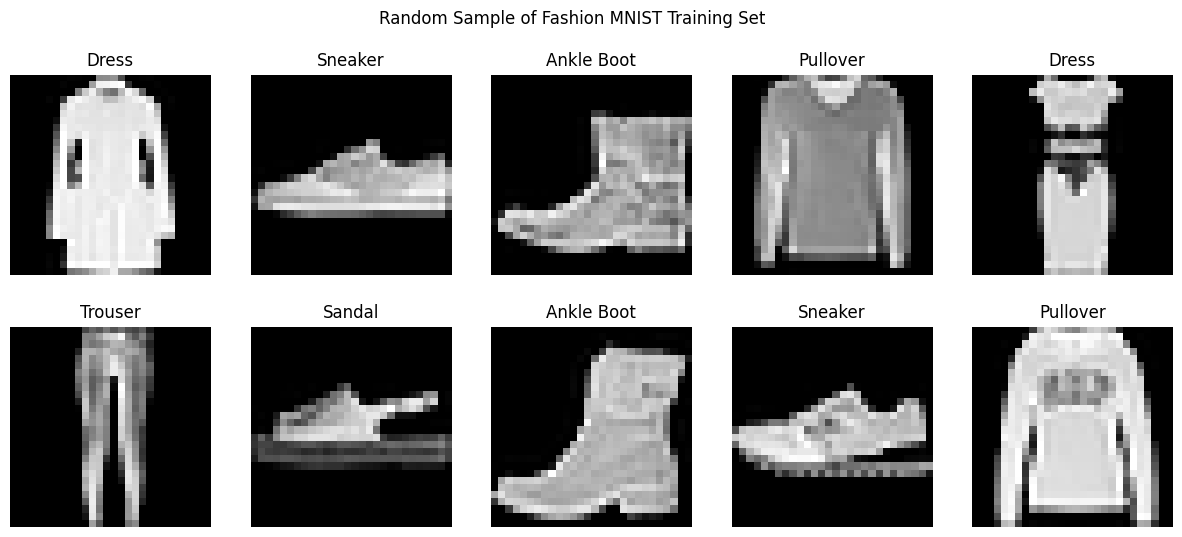

In [4]:
from plotting_tools import plot_randomsample

plot_randomsample(FMNIST_traindata, labels_map, title="Random Sample of Fashion MNIST Training Set")
plt.show()

# Neural Network Models

Initializing CNN and MLP models for application

In [5]:
from plotting_tools import plot_predictions

## CNN Network

Training convolutional neural network (see CNN_model.py) with standard specs -- cross entropy loss, PyTorch Adam optimizer, $10^{-4}$ learning rate

In [6]:
from CNN_model import CNN, train_CNN

model_CNN = CNN()
model_CNN.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.0001
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate)

train_CNN(model_CNN, FMNIST_trainloader, FMNIST_testloader, optimizer, error, epochs=5)

/Users/christopher/Documents/University/Supplementals/Projects/uap_exploration/.uap_exploration/lib/python3.11/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 1000, Loss: 0.31279411911964417, Accuracy: 88.33999633789062%
Iteration: 2000, Loss: 0.14273768663406372, Accuracy: 89.16999816894531%
Iteration: 3000, Loss: 0.24720436334609985, Accuracy: 89.62000274658203%


Displaying random sample of data points in testing dataset and CNN performance

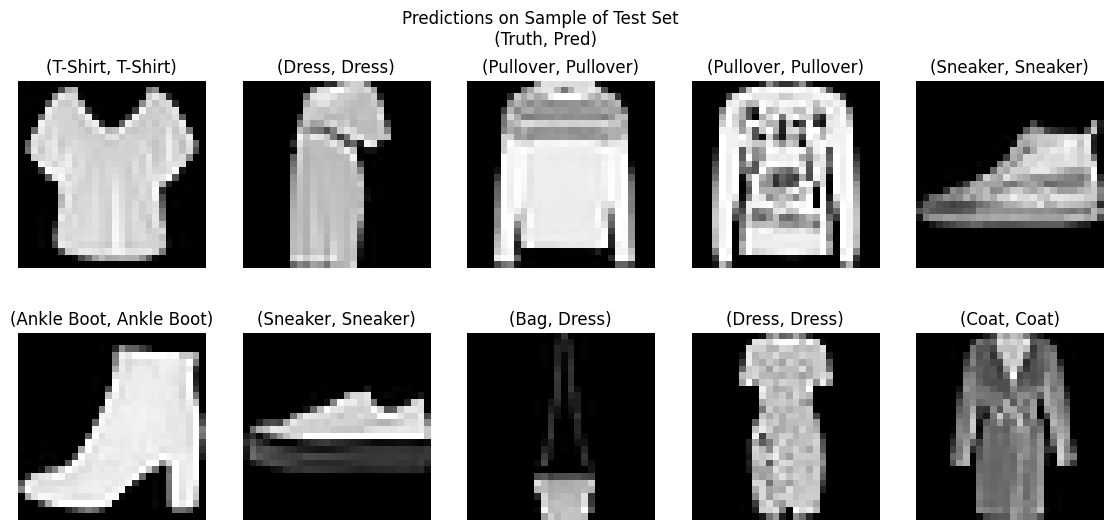

In [7]:
cnn_preds = plot_predictions(model_CNN, FMNIST_testdata, labels_map, device=device)
plt.show()

## MLP Model

Simplified MLP (fully-connected) neural network (see MLP_model.py). Training with specifications identical to CNN above.

In [8]:
from MLP_model import MLP, train_MLP

model_MLP = MLP()
model_MLP.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=1e-4)

train_MLP(model_MLP, FMNIST_trainloader, FMNIST_testloader, optimizer, loss_function, epochs=5)

Iteration: 1000, Loss: 0.6726551651954651, Accuracy: 74.73999786376953%
Iteration: 2000, Loss: 0.6118248105049133, Accuracy: 78.27999877929688%
Iteration: 3000, Loss: 0.5281112194061279, Accuracy: 80.7699966430664%


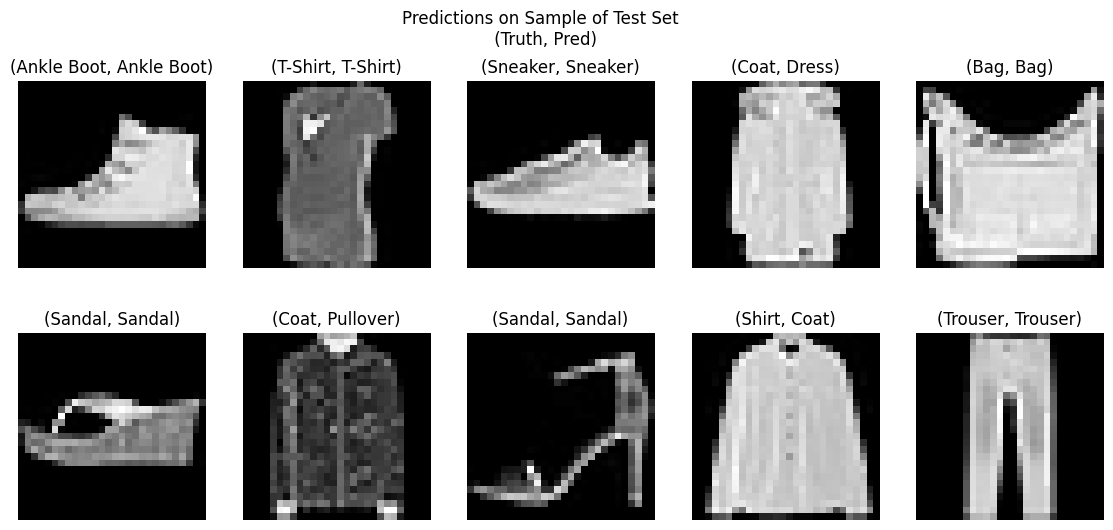

In [9]:
mlp_preds = plot_predictions(model_MLP, FMNIST_testdata, labels_map, device=device)
plt.show()

# UAP and Deepfool Algorithms

In [10]:
from plotting_tools import plot_perturbance
from UAP_generation import generate_uap, get_foolingrate

## Generating UAPs for NNs

In [11]:
uap_MLP = generate_uap(device, FMNIST_traindata, FMNIST_testloader, model_MLP, xi=0.1, p=np.inf, max_iter_uni=5)

Maximal fooling rate after 5 iterations: 65.95


Example of MLP performance with perturbation applied

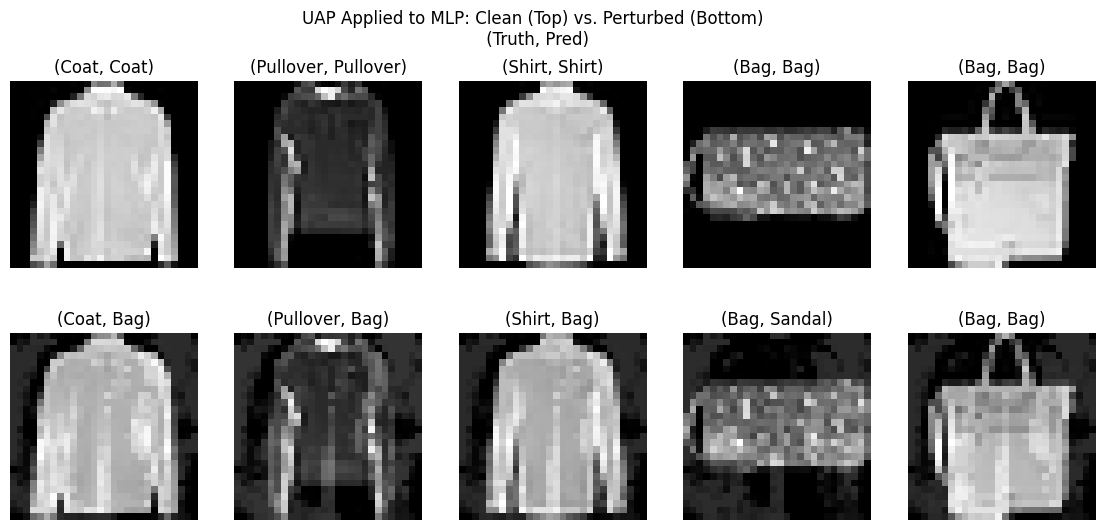

In [13]:
plot_perturbance(model_MLP, FMNIST_testdata, uap_MLP, labels_map, device)
plt.show()

In [14]:
uap_CNN = generate_uap(device, FMNIST_traindata, FMNIST_testloader, model_CNN, xi=0.1, p=np.inf, max_iter_uni=5)

Maximal fooling rate after 5 iterations: 58.38


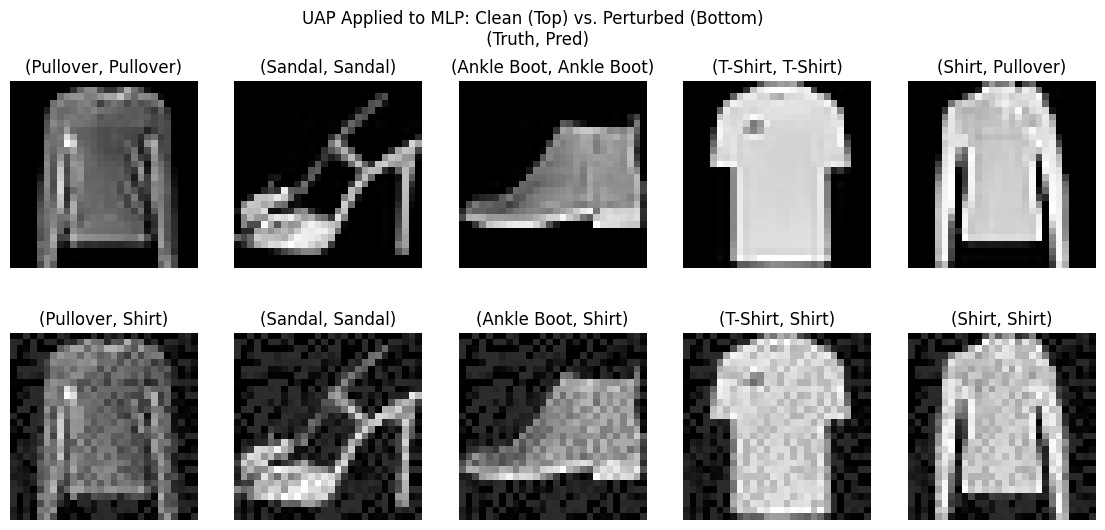

In [15]:
plot_perturbance(model_CNN, FMNIST_testdata, uap_CNN, labels_map, device)
plt.show()

# PCA

Exploring UAP with PCA

In [16]:
from sklearn.decomposition import PCA
# PCA FOR TRAINING DATA

data_np = FMNIST_traindata.data.numpy() / 255
# data_np ~ (60000, 28, 28)
X = data_np.reshape((60000, 784))
# X ~ (60000, 784)

pca = PCA()
pca.fit(X)

PCA()

Plotting variance across principal components (sorted).

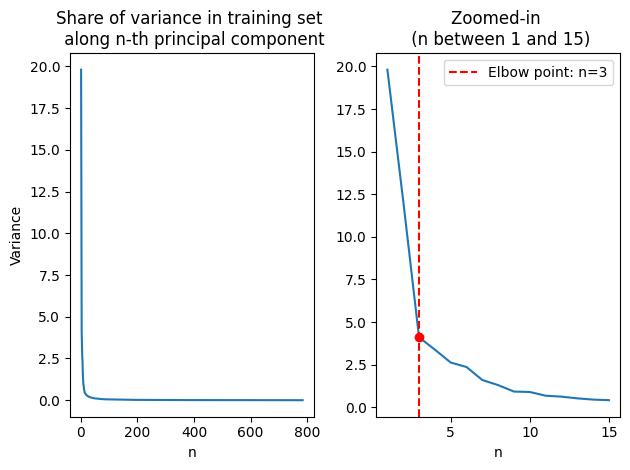

In [17]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(784) + 1, pca.explained_variance_)
plt.title("Share of variance in training set \n along n-th principal component")
plt.ylabel("Variance")
plt.xlabel("n")

plt.subplot(1, 2, 2)
plt.plot(np.arange(15) + 1, pca.explained_variance_[:15])
plt.plot(3, pca.explained_variance_[2], marker="o", color="red")
plt.axvline(x = 3, color = 'r', ls="--", label = 'Elbow point: n=3')
plt.title("Zoomed-in \n (n between 1 and 15)")
plt.xlabel("n")

plt.tight_layout()
plt.legend(loc='upper right')

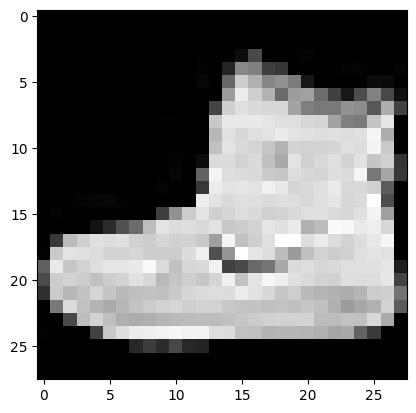

In [19]:
# Using the all 784 vectors for testing

# M = 784
# PCA_projection = pca.components_#[0:M, :]
# X_proj = X @ PCA_projection.T @ PCA_projection

# Plotting sample point for control
# plt.imshow(X_proj[0, :].reshape((28, 28)), cmap='gray')

## Composition of UAP

Looking at PC make-up of algorithm-generated UAP to explore relevance

Index of dominant PC projection:  4


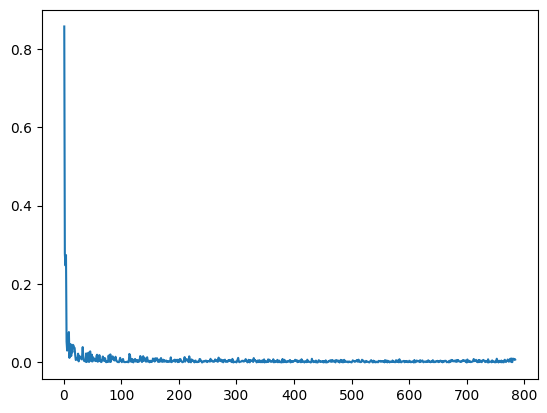

In [18]:
v = uap_MLP.reshape(1, 784)
uap_weights = pca.transform(v)
uap_weights_normalized = uap_weights / np.linalg.norm(uap_weights)
print("Index of dominant PC projection: ", np.argmax(uap_weights_normalized) + 1)

plt.plot(np.arange(784) + 1, np.abs(uap_weights_normalized.T))

### PCA for CNN

Index of dominant PC projection:  3


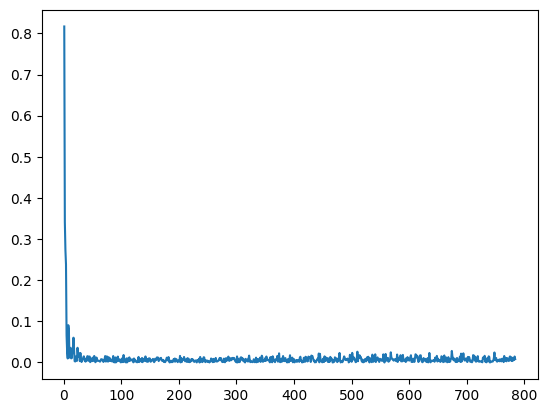

In [19]:
v = uap_CNN.reshape(1, 784)
uap_weights = pca.transform(v)
uap_weights_normalized = uap_weights / np.linalg.norm(uap_weights)
print("Index of dominant PC projection: ", np.argmax(uap_weights_normalized) + 1)

plt.plot(np.arange(784) + 1, np.abs(uap_weights_normalized.T))

# Performance of PCs as UAPs

This area is a bit of a mess for the time-being. I'm looking into the fooling rate of individual PCs across the models.

In [23]:
from UAP_generation import get_foolingrate

In [38]:
xi = 0.1
r_raw = np.random.uniform(-1, 1, (1, 784)).astype(np.float32)
# r_norm = r_raw / np.linalg.norm(r_raw)
r = r_raw * (xi / np.max(np.abs(r_raw)))
r_tensor = torch.tensor(r.reshape((1,1,28,28))).to(device)

control_fr = get_foolingrate(model_MLP, FMNIST_testloader, r_tensor)
control_fr

/var/folders/pm/fbzw1mlj1g126y2_nzqfk5ph0000gn/T/ipykernel_96180/1887143378.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_images = images + torch.tensor(perturbation).to(device)


(82.08, 2.06)

In [28]:
# MLP Modelling

fooling_rates = []

M = 150

for i in range(M):
    idx = i * 5
    u_raw = pca.components_[idx, :].astype(np.float32)
    u = u_raw * (xi / np.max(np.abs(u_raw)))
    u_tensor = torch.tensor(u.reshape((1, 1, 28, 28))).to(device)

    _, fooling_rate = get_foolingrate(model_MLP, FMNIST_testloader, u_tensor)
    fooling_rates.append(fooling_rate)

/var/folders/pm/fbzw1mlj1g126y2_nzqfk5ph0000gn/T/ipykernel_96180/1887143378.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_images = images + torch.tensor(perturbation).to(device)


1


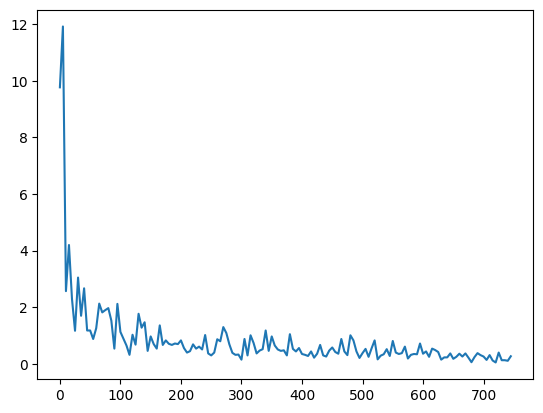

In [39]:
plt.plot(np.arange(M) * 5, fooling_rates)
print(np.argmax(fooling_rates))

In [49]:
fooling_rates_zoom = []

M = 10

for i in range(M):
    idx = i
    u_raw = pca.components_[idx, :].astype(np.float32)
    u = u_raw * (xi / np.max(np.abs(u_raw)))
    u_tensor = torch.tensor(u.reshape((1, 1, 28, 28))).to(device)

    _, fooling_rate = get_foolingrate(model_MLP, FMNIST_testloader, u_tensor)
    fooling_rates_zoom.append(fooling_rate)

/var/folders/pm/fbzw1mlj1g126y2_nzqfk5ph0000gn/T/ipykernel_96180/1887143378.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_images = images + torch.tensor(perturbation).to(device)


2


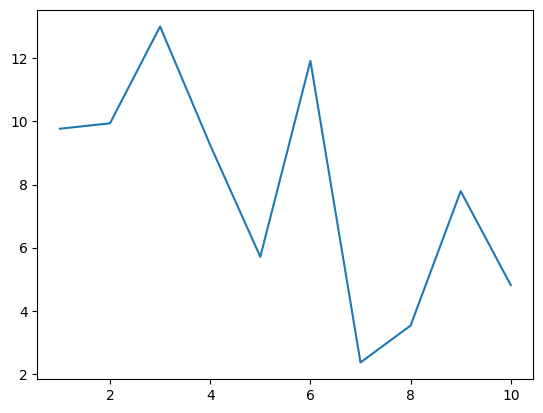

In [51]:
plt.plot(np.arange(M) + 1, fooling_rates_zoom)
print(np.argmax(fooling_rates_zoom))

In [42]:
xi = 0.1
# Get most-trained dimension
u_raw = pca.components_[0, :].astype(np.float32)
u = u_raw * (xi / np.max(np.abs(u_raw)))
u_tensor = torch.tensor(u.reshape((1, 1, 28, 28))).to(device)
# Get least-trained dimension
v_raw = pca.components_[-1, :].astype(np.float32)
v = v_raw * (xi / np.max(np.abs(v_raw)))
v_tensor = torch.tensor(v.reshape((1, 1, 28, 28))).to(device)
# Control
r_raw = np.random.uniform(-1, 1, (1, 784)).astype(np.float32)
r_norm = r_raw / np.linalg.norm(r_raw)
r = r_norm * (xi / np.max(np.abs(r_norm)))
r_tensor = torch.tensor(r.reshape((1,1,28,28))).to(device)

maxvar_fr = get_foolingrate(model_CNN, FMNIST_testloader, u_tensor)
minvar_fr = get_foolingrate(model_CNN, FMNIST_testloader, v_tensor)
control_fr = get_foolingrate(model_CNN, FMNIST_testloader, r_tensor)

/var/folders/pm/fbzw1mlj1g126y2_nzqfk5ph0000gn/T/ipykernel_96447/1844934995.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_images = images + torch.tensor(perturbation).to(device)
/Users/christopher/Documents/University/Supplementals/Projects/UAP/.UAP/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [44]:
print("Max Var perturb.: ", maxvar_fr)
print("Min Var perturb.: ", minvar_fr)
print("Control perturb.: ", control_fr)

Max Var perturb.:  (90.95, 2.17)
Min Var perturb.:  (90.95, 0.07)
Control perturb.:  (90.95, 12.83)


In [24]:
fooling_rates_zoom = []

M = 15
xi = 0.1

for i in range(M):
    idx = i
    u_raw = pca.components_[idx, :].astype(np.float32)
    u = u_raw * (xi / np.max(np.abs(u_raw)))
    u_tensor = torch.tensor(u.reshape((1, 1, 28, 28))).to(device)

    _, fooling_rate = get_foolingrate(device, model_CNN, FMNIST_testloader, u_tensor)
    fooling_rates_zoom.append(fooling_rate)

/Users/christopher/Documents/University/Supplementals/Projects/UAP/UAP_generation.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_images = images + torch.tensor(perturbation).to(device)
/Users/christopher/Documents/University/Supplementals/Projects/UAP/.UAP/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


12


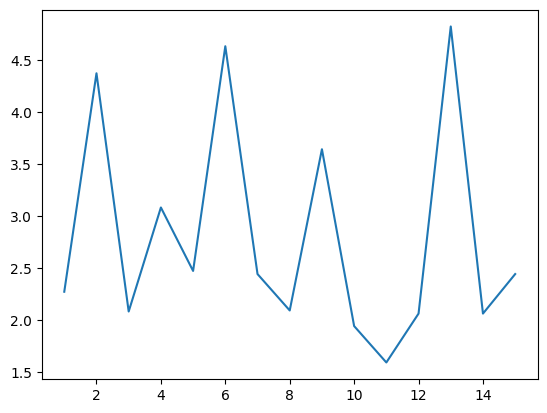

In [25]:
plt.plot(np.arange(M) + 1, fooling_rates_zoom)
print(np.argmax(fooling_rates_zoom))

In [51]:
fooling_rates = []

M = 150

for i in range(M):
    idx = i * 5
    u_raw = pca.components_[idx, :].astype(np.float32)
    u = u_raw * (xi / np.max(np.abs(u_raw)))
    u_tensor = torch.tensor(u.reshape((1, 1, 28, 28))).to(device)

    _, fooling_rate = get_foolingrate(model_CNN, FMNIST_testloader, u_tensor)
    fooling_rates.append(fooling_rate)

/var/folders/pm/fbzw1mlj1g126y2_nzqfk5ph0000gn/T/ipykernel_96447/1844934995.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_images = images + torch.tensor(perturbation).to(device)


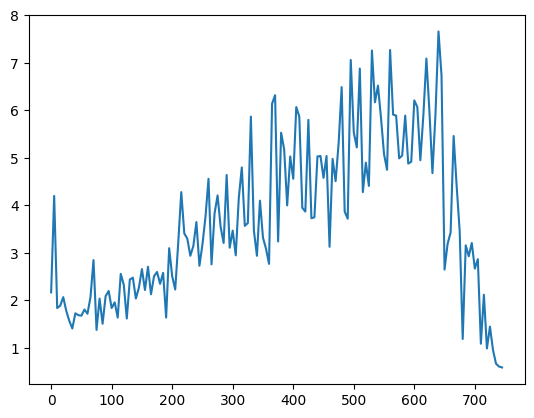

In [52]:
plt.plot(np.arange(M) * 5, fooling_rates)

In [255]:
xi = 0.1
# Get most-trained dimension
u_raw = pca.components_[3, :].astype(np.float32)
u = u_raw * (xi / np.max(np.abs(u_raw)))
u_tensor = torch.tensor(u.reshape((28, 28))) # .to(device)
# Get least-trained dimension
v_raw = pca.components_[-4, :].astype(np.float32)
v = v_raw * (xi / np.max(np.abs(v_raw)))
v_tensor = torch.tensor(v.reshape((28, 28))) # .to(device)
# Control
r = xi * np.random.rand(784, 1).astype(np.float32)
r_tensor = torch.tensor(r.reshape((28,28))) # .to(device)

maxvar_fr = get_FR_mlp(model_mlp, test_loader, u_tensor)
minvar_fr = get_FR_mlp(model_mlp, test_loader, v_tensor)
control_fr = get_FR_mlp(model_mlp, test_loader, r_tensor)

In [256]:
print("Max Var perturb.: ", maxvar_fr)
print("Min Var perturb.: ", minvar_fr)
print("Control perturb.: ", control_fr)

Max Var perturb.:  (81.2, 8.21)
Min Var perturb.:  (81.2, 0.14)
Control perturb.:  (81.2, 8.87)
